# Project 1, Part 4, Holiday Analytics

University of California, Berkeley
Master of Information and Data Science (MIDS) program
w205 - Fundamentals of Data Engineering

Student: Landon Morin

Year: 2022

Semester: Spring

Section:


# Included Modules and Packages

Code cell containing your includes for modules and packages

In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as mticker
from calendar import day_name


import psycopg2

# Supporting code

Code cells containing any supporting code, such as connecting to the database, any functions, etc.  Remember you can use any code from the labs.

In [3]:
# pandas puts all numeric values from postgres to float
# if it will fit in an integer, change it to integer
#

def my_select_query_pandas(query, rollback_before_flag, rollback_after_flag):
    "function to run a select query and return rows in a pandas dataframe"
    
    if rollback_before_flag:
        connection.rollback()
    
    df = pd.read_sql_query(query, connection)
    
    if rollback_after_flag:
        connection.rollback()
    
    # fix the float columns that really should be integers
    
    for column in df:
    
        if df[column].dtype == "float64":

            fraction_flag = False

            for value in df[column].values:
                
                if not np.isnan(value):
                    if value - math.floor(value) != 0:
                        fraction_flag = True

            if not fraction_flag:
                df[column] = df[column].astype('Int64')
    
    return(df)

In [4]:
connection = psycopg2.connect(
    user = "postgres",
    password = "ucb",
    host = "postgres",
    port = "5432",
    database = "postgres"
)

In [5]:
cursor = connection.cursor()

## How do holidays affect the sales, considering both the actual holiday, and the days before and after the holiday? 

## Create an executive summary explaining how holidays have affected sales. 

## You must support your summary with data, in the form of output of queries, data visualization, etc. There is a 1 query minimum.

In [7]:
rollback_before_flag = True
rollback_after_flag = True

query = """

select sa.sale_date,
       h.holiday_date,
       to_char(date_trunc('day', sa.sale_date), 'Day') as day_of_week,
       to_char(date_trunc('day', h.holiday_date), 'Day') as day_of_week_hol,
       sum(sa.total_amount) as total_sales,
       h.description as holiday 
from sales as sa
    full join holidays as h
        on h.holiday_date = sa.sale_date
group by sa.sale_date, h.holiday_date
order by sa.sale_date, extract(dow from sa.sale_date)

"""

df = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

df['sale_date'] = df['sale_date'].combine_first(df['holiday_date'])
df = df.drop('holiday_date', axis = 1)
df['day_of_week'] = df['day_of_week'].combine_first(df['day_of_week_hol'])
df = df.drop('day_of_week_hol', axis = 1)
df = df.sort_values(by = 'sale_date')
df = df.reset_index()
df = df.drop('index', axis = 1)
df['sale_date'] = pd.to_datetime(df['sale_date'])
df['total_sales'] = df['total_sales'].fillna(0)
df.head()

,sale_date,day_of_week,total_sales,holiday
0,2020-01-01,Wednesday,133776,New Year's Day
1,2020-01-02,Thursday,261120,None
2,2020-01-03,Friday,263076,None
3,2020-01-04,Saturday,400368,None
4,2020-01-05,Sunday,394992,None


In [8]:
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_sales = df.groupby('day_of_week').mean()
dow_sales = dow_sales.rename(columns={'total_sales':'average_sales'}).reset_index()
dow_sales['day_of_week'] = dow_sales['day_of_week'].str.strip()
dow_sales['day_of_week'] = pd.Categorical(dow_sales['day_of_week'], categories=cats, ordered=True)
dow_sales = dow_sales.sort_values('day_of_week')

dow_sales

,day_of_week,average_sales
1,Monday,253225.384615
5,Tuesday,132602.538462
6,Wednesday,263255.773585
4,Thursday,261031.018868
0,Friday,247665.923077
2,Saturday,373489.615385
3,Sunday,357482.076923


In [9]:
no_hol = df[df['holiday'].isna()]
dow_sales_no_hol = no_hol.groupby('day_of_week').mean()
dow_sales_no_hol = dow_sales_no_hol.rename(columns={'total_sales':'average_sales'}).reset_index()
dow_sales_no_hol['day_of_week'] = dow_sales_no_hol['day_of_week'].str.strip()
dow_sales_no_hol['day_of_week'] = pd.Categorical(dow_sales_no_hol['day_of_week'], categories=cats, ordered=True)
dow_sales_no_hol = dow_sales_no_hol.sort_values('day_of_week')
dow_sales_no_hol

,day_of_week,average_sales
1,Monday,263314.75
5,Tuesday,132602.538462
6,Wednesday,265624.705882
4,Thursday,266050.846154
0,Friday,252522.117647
2,Saturday,378166.823529
3,Sunday,371087.510204


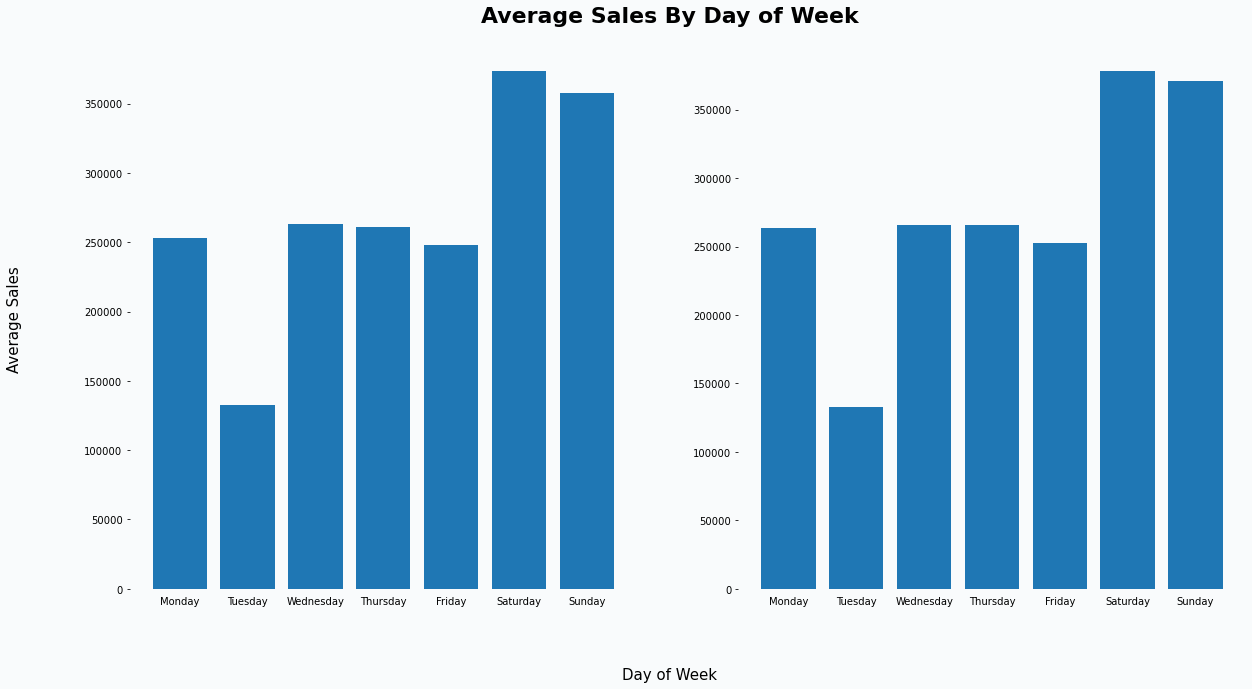

In [10]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
x1 = dow_sales['day_of_week'].values
y1 = dow_sales['average_sales'].values
x2 = dow_sales_no_hol['day_of_week'].values
y2 = dow_sales_no_hol['average_sales'].values
ax1.bar(x1, y1)
ax2.bar(x2, y2)
ax1.tick_params(bottom=False)
ax2.tick_params(bottom=False)
ax1.set_frame_on(False)
ax2.set_frame_on(False)

fig.text(0.5, 0, 'Day of Week', ha='center', fontsize = 15)
fig.text(.04, .5, 'Average Sales', va='center', rotation='vertical', fontsize = 15)
fig.text(
    x=0.5, 
    y=0.92,
    s="Average Sales By Day of Week",
    ha="center",
    va="center",
    ma="center",
    fontsize=22,
    fontweight="bold"
)

# Sets background color
fig.set_facecolor("#f9fbfc")

In [11]:
rollback_before_flag = True
rollback_after_flag = True


query = """

select case 
           when h.description is null then extract('week' from sa.sale_date)
           else extract('week' from h.holiday_date)
           end week,
       sum(sa.total_amount) as total_sales,
       h.description as holiday,
       to_char(date_trunc('day', h.holiday_date), 'Day') as holiday_day
from sales as sa
    full join holidays as h
        on h.holiday_date = sa.sale_date
group by week, h.description, h.holiday_date
order by week


"""

df1 = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df1.loc[:,'total_sales'] = df1.loc[:,'total_sales'].ffill()

df1 = df1.sort_values('holiday').drop_duplicates(subset = 'week', keep = 'first')
df1 = df1.sort_values('week')
df1['holiday'] = df1['holiday'].fillna('No Hol')
df1

,week,total_sales,holiday,holiday_day
0,1,133776,New Year's Day,Wednesday
2,2,1996956,No Hol,None
3,3,1321044,No Hol,None
4,4,130740,MLK Day,Monday
6,5,1981956,No Hol,None
7,6,1996632,No Hol,None
8,7,1330068,No Hol,None
9,8,135228,President's Day,Monday
11,9,1992648,No Hol,None
12,10,2004984,No Hol,None


In [12]:
week_sales = df1.groupby('holiday').mean('total_sales')
week_sales.reset_index()
week_sales = week_sales.drop('week', axis = 1)
week_sales['total_sales'] = week_sales['total_sales'].astype(int)
week_sales = week_sales.reset_index()
week_sales

,holiday,total_sales
0,Christmas,1981560
1,Easter,136164
2,Father's Day,135120
3,Independence Day,134952
4,Labor Day,130020
5,MLK Day,130740
6,Memorial Day,132624
7,Mother's Day,134496
8,New Year's Day,133776
9,No Hol,1899063


In [42]:
idx = df[df['holiday'].isna() == False].index
idx

holiday_pad1 = pd.DataFrame()
for i in idx: 
    if i > 7:
        basedate = df.loc[i]['sale_date']
        temp = df.loc[i-7:i]
        temp['time_since'] = temp['sale_date'].apply(lambda x: (x.to_pydatetime() - basedate).days)
        temp['7 Day Prior Total Sales'] = temp['total_sales'].sum()
        holiday_pad1 = holiday_pad1.append(temp)
        del temp
    else: 
        basedate = df.loc[i]['sale_date']
        temp = df.loc[i: i+8]
        temp['time_since'] = temp['sale_date'].apply(lambda x: (x.to_pydatetime() - basedate).days)
        temp['7 Day Prior Total Sales'] = temp['total_sales'].mean()
        holiday_pad1 = holiday_pad1.append(temp)
        del temp
        
holiday_pad1 = holiday_pad1.groupby('holiday').mean('total_holiday_sales')
holiday_pad1 = holiday_pad1.reset_index()
holiday_pad1 = holiday_pad1.drop(['total_sales', 'time_since'], axis = 1)
holiday_pad1 = holiday_pad1.append(week_sales.loc[week_sales['holiday'] == 'No Hol'])
holiday_pad1['7 Day Prior Total Sales'].fillna(holiday_pad1['total_sales'], inplace = True)
holiday_pad1.drop('total_sales', axis = 1, inplace = True)
holiday_pad1 = holiday_pad1.rename(columns = {'7 Day Prior Total Sales':'week_total_sales'})

<ipython-input-42-4a1ba8b7dd47>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['time_since'] = temp['sale_date'].apply(lambda x: (x.to_pydatetime() - basedate).days)
<ipython-input-42-4a1ba8b7dd47>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['7 Day Prior Total Sales'] = temp['total_sales'].mean()
<ipython-input-42-4a1ba8b7dd47>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

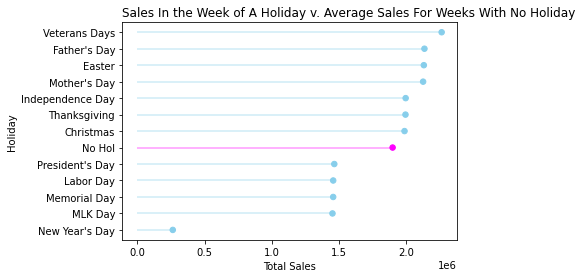

In [43]:
# Reorder it based on values:
ordered_week = holiday_pad1.sort_values(by='week_total_sales')
my_range=range(1,len(ordered_week.index)+1)
 
# Create a color if the group is "B"
my_color=np.where(ordered_week['holiday']=='No Hol', 'magenta', 'skyblue')
my_size=np.where(ordered_week['holiday']=='B', 70, 30)
 
# The horizontal plot is made using the hline() function
plt.hlines(y=my_range, xmin=0, xmax=ordered_week['week_total_sales'], color=my_color, alpha=0.4)
plt.scatter(ordered_week['week_total_sales'], my_range, color=my_color, s=my_size, alpha=1)
 
# Add title and axis names
plt.yticks(my_range, ordered_week['holiday'])
plt.title("Sales In the Week of A Holiday v. Average Sales For Weeks With No Holiday", loc='left')
plt.xlabel('Total Sales')
plt.ylabel('Holiday')

# show the graph
plt.show()


In [ ]:
idx = df[df['holiday'].isna() == False].index
idx

holiday_pad = pd.DataFrame()
temp = pd.DataFrame()
for i in idx: 
    if i > 5:
        basedate = df.loc[i]['sale_date']
        temp = df.iloc[i-7: i+8]
        temp['holiday'] = df.iloc[i]['holiday']
        temp['time_since'] = temp['sale_date'].apply(lambda x: (x.to_pydatetime() - basedate).days)
        temp['period_avg_sales'] = temp['total_sales'].mean()
        holiday_pad = holiday_pad.append(temp)
        del temp
    else: 
        basedate = df.loc[i]['sale_date']
        temp = df.iloc[i: i+8]
        temp['holiday'] = df.iloc[i]['holiday']
        temp['time_since'] = temp['sale_date'].apply(lambda x: (x.to_pydatetime() - basedate).days)
        temp['period_avg_sales'] = temp['total_sales'].mean()
        holiday_pad = holiday_pad.append(temp)
        del temp


In [ ]:
holiday_pad.tail(50)

In [ ]:
holidays = holiday_pad['holiday'].unique()

hol1 = holidays[0]

def thousands_formatter(x, pos):
    return f'${x / 1000}'

In [ ]:
def add_label(x, y, z, fontsize, color, ax):
    PAD = -150000
    ax.annotate(
        f"${round(float(z)/1000, 2)}", 
        xy=(x, y + PAD), 
        ha="center", 
        va="bottom",
        fontsize=fontsize,
        fontweight='bold',
        zorder=12,
        color=color
    )

In [ ]:
def plot_country(holiday, data, ax):
    
    for hol_inner in holidays:
    # Filter data to keep rows of the country
        d = data[data["holiday"] == hol_inner] 
        x = list(d["time_since"].values.astype(float))
        y = list(d["total_sales"].values.astype(float))
        z = list(d['period_avg_sales'].values)

        if hol_inner == holiday:
            ax.plot(x, y, color="#0b53c1", lw=2.4, zorder=10)
            ax.scatter(x, y, fc="w", ec="#0b53c1", s=60, lw=2.4, zorder=12)
            add_label(x[-1], y[-1], z[1], 12, '#0b53c1', ax)

        else:
            ax.plot(x, y, color="#BFBFBF", lw=1.5)
    
    ax.xaxis.set_major_locator(mticker.MaxNLocator(4))
    ticks_loc = ax.get_xticks().tolist()
    ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
    
    ax.yaxis.set_ticks_position('none') 
    ax.yaxis.set_major_formatter(FuncFormatter(thousands_formatter))
   
    ax.tick_params(bottom=False)
    ax.set_frame_on(False)

    ax.set_title(holiday, fontsize=14, fontweight=500)
    
    return ax


fig, axes = plt.subplots(4, 3, sharex=True, sharey=True, figsize=(14, 7.5))
for idx, (ax, holiday) in enumerate(zip(axes.ravel(), holidays)):
    plot_country(holiday, holiday_pad, ax)


fig.subplots_adjust(wspace=0.1, left=0.025, right=0.975, bottom=0.11, top=0.82)
fig.tight_layout(pad = 1.5)
# Adds title.
fig.text(
    x=0.5, 
    y=1,
    s="Total Daily Sales For The 7 Days Pre and Post Holiday",
    ha="center",
    va="center",
    ma="center",
    fontsize=22,
    fontweight="bold"
)

fig.text(0.5, 0, 'Days Away From Holiday', ha='center', fontsize = 15)
fig.text(-.04, .5, 'Total Sales in Thousands', va='center', rotation='vertical', fontsize = 15)
# Sets background color
fig.set_facecolor("#f9fbfc")


